## Using Latent Dirichlet Allocation and Topic Modeling to Gauge Uses for Chat-GPT

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import html
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.metrics.pairwise import cosine_similarity

First, read in large dataset. This dataset is not uploaded to Github as it is too large, but please download it the link below, create a 'Data' file in the project directory, and upload it there.

https://www.kaggle.com/datasets/khalidryder777/500k-chatgpt-tweets-jan-mar-2023

In [61]:
# Make dataframe local variable
data = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/Twitter Jan Mar 2.csv", encoding='UTF-8')

# Verify that the data is loaded
print(data.head(5))


                        date                   id  \
0  2023-03-29 22:58:21+00:00  1641213230730051584   
1  2023-03-29 22:58:18+00:00  1641213218520481805   
2  2023-03-29 22:57:53+00:00  1641213115684536323   
3  2023-03-29 22:57:52+00:00  1641213110915571715   
4  2023-03-29 22:57:26+00:00  1641213003260633088   

                                             content        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         0.0            0.0  
4         0.0            0.0  


# Data Cleaning

To combat bot activity and spam, delete any duplicate tweets that might interfere with the analysis.

In [46]:
# Creat a mask of all duplicate tweets keeping only the first instance
duplicate_mask = data.duplicated(subset=['content'], keep='first')

# Filter out the duplicated data
filtered_df = data[~duplicate_mask]

In [49]:
nan_rows = filtered_df[filtered_df.isnull().any(axis=1)]
print(nan_rows)

                                                     date  \
34984                           2023-03-25 05:41:21+00:00   
34985              See here -&gt; https://t.co/gepBwf9zHD   
34986   #AITechnologies #BingAI #ChatGPT #RootOutDiscr...   
56153                           2023-03-22 15:30:06+00:00   
114179                          2023-03-15 09:48:04+00:00   
114180  #DiscoverAi #SpaceAi #Space #Ai #Web3 #Metaver...   
172934                          2023-03-04 02:48:31+00:00   
203675                          2023-02-26 10:02:18+00:00   
203676  #casino #bet #gambling #sportingbet #betupp #c...   
213136                          2023-02-24 04:48:33+00:00   
213137  #casino #Web3 #Metaverse #nfts #winycasino #ca...   
222097                          2023-02-22 16:37:55+00:00   
222100   Try it out today and let me know what you think!   
230597                          2023-02-21 07:06:43+00:00   
236890                          2023-02-20 05:02:18+00:00   
236891  #DiscoverAi #Dis

Begin data cleaning by dropping missing values and resetting index to make processing of remaining tweets possible.

In [51]:
# Check missing values in the 'content' column
missing_content = data[data['content'].isnull()]

# Drop rows with missing content
data.dropna(subset=['content'], inplace=True)

# Reset index after dropping rows
data.reset_index(drop=True, inplace=True)

In [52]:
# Assuming 'df' is your DataFrame
nan_rows = data[data.isnull().any(axis=1)]
print(nan_rows)

                                                     date  \
34984                           2023-03-25 05:41:21+00:00   
34985   #AITechnologies #BingAI #ChatGPT #RootOutDiscr...   
56152                           2023-03-22 15:30:06+00:00   
56153                             https://t.co/XON7aHCRHU   
114177                          2023-03-15 09:48:04+00:00   
114178  #DiscoverAi #SpaceAi #Space #Ai #Web3 #Metaver...   
172932                          2023-03-04 02:48:31+00:00   
172933  #DiscoverAi #Discover #Ai #Web3 #Metaverse #nf...   
203673                          2023-02-26 10:02:18+00:00   
203674  #casino #bet #gambling #sportingbet #betupp #c...   
213134                          2023-02-24 04:48:33+00:00   
213135  #casino #Web3 #Metaverse #nfts #winycasino #ca...   
222095                          2023-02-22 16:37:55+00:00   
222096   Try it out today and let me know what you think!   
230593                          2023-02-21 07:06:43+00:00   
230594  #Enticing #Ai #A

In [53]:
# Write to new CSV
filtered_df.to_csv('filtered_tweets.csv', index=False)

You must first initialize data_subset as a truncated copy of the first half of the dataset. Later code will help write the cleaned data to a csv so it doesn't need to be instantiated as a variable every time.

In [28]:
# Create a new truncated subset of data
data_subset = data.head(250000).copy()

If the cleaned csv has already been created, read it in here.

In [54]:
#If the data subset has already been created, run this block instead of cleaning repeatedly.
data_subset = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/filtered_tweets.csv", encoding='UTF-8')

It's important to calculate descriptive statistics to get a better understanding of our data. Here are the descriptive statistics for the engagement variables and the length of the datasets being used.

In [55]:
# Calculate number of rows
data_len = len(data_subset)

# Calculate descriptive statistics for like_count
like_count_stats = data_subset['like_count'].describe()

# Calculate descriptive statistics for retweet_count
retweet_count_stats = data_subset['retweet_count'].describe()

# Calculate num rows cleaned data
data_subset_len = len(data_subset)

print("All tweets length:", data_len)

print("\nDescriptive statistics for like_count:", like_count_stats)

print("\nDescriptive statistics for retweet_count:", retweet_count_stats)

print("\nClean tweets length:", data_subset_len)

All tweets length: 493745

Descriptive statistics for like_count: count    493705.000000
mean          6.955390
std         209.479346
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max       64094.000000
Name: like_count, dtype: float64

Descriptive statistics for retweet_count: count    493705.000000
mean          1.445483
std          43.737851
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       16080.000000
Name: retweet_count, dtype: float64

Clean tweets length: 493745


## Alternate Data Cleaning Tool

This is a more customizeable version of a tweet cleaning tool that can be customized to your liking. However, I chose to use the NLTK stopwords library instead because it was both quicker and more effective. Feel free to make use of this if you prefer. 

In [ ]:
# Code to clean the data and write it to a new csv file


# Words to clean
words_to_clean = ["chatgpt", "ai", "gpt", "chat", "gpt4", "https", "artificialintelligence", "http", "like"]

# Instantiate an empty list to store cleaned tweets
clean_tweets = []

# Iterate over each tweet in data_subset
for tweet in data_subset['content']:
    
    # Manage HTML artifacts
    decoded_tweet = html.unescape(tweet)

    #Lowecase each tweet
    cleaned_tweet = decoded_tweet.lower()

    # Clean tweet by replacing specified words with spaces
    for word in words_to_clean:
        cleaned_tweet = cleaned_tweet.replace(word, '')
    # Replace special characters with spaces
    cleaned_tweet = cleaned_tweet.replace('\r',' ')
    cleaned_tweet = cleaned_tweet.replace('\n',' ')
    cleaned_tweet = cleaned_tweet.replace('. ',' ')
    cleaned_tweet = cleaned_tweet.replace(', ',' ')
    # Append cleaned tweet to the list
    clean_tweets.append(cleaned_tweet.strip())  # strip removes leading/trailing whitespaces

# Add cleaned tweets to data_subset
data_subset['clean_tweet'] = clean_tweets

# Remove duplicates based on similarity
similar_level = 85  # Sets baseline similarity level
duplicate_index = []  # Initializes list for tweet indices to remove

for original in range(len(data_subset)-1):
    print((original / len(data_subset) * 100), '%')
    for compared in range(original+1, len(data_subset)):
        if compared not in duplicate_index:
            if fuzz.ratio(data_subset['clean_tweet'][original], data_subset['clean_tweet'][compared]) >= similar_level:
                duplicate_index.append(compared)

# Drop duplicate tweets
data_subset.drop(duplicate_index, inplace=True)
data_subset.reset_index(drop=True, inplace=True)

# Write cleaned data to a new CSV file
data_subset.to_csv('data/data_5,000_rows.csv', index=False)

## Primary Data Cleaning Process

Download NLTK data for data cleaning.

In [56]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/scottpetersen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scottpetersen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/scottpetersen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Initialize a lemmatizer to remove unnecessary word variation:

In [57]:
# Initialize NLTK's WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

Create a built-in list of stopwords and punctuation to be cleaned later using NLTK's libraries.

In [58]:
# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

CUSTOM list of words to remove from the dataset. 

In [59]:
# Words to clean
words_to_clean = ["chatgpt", "ai", "gpt", "chat", "gpt4", "https", "artificialintelligence", "http", "like", "openai"]

Code to add a new column to the data subset called 'clean_tweet' that has been decoded with UTF-8, tokenized, lemmatized, and cleaned of custom word list.

In [62]:
# Function to preprocess a single tweet
def preprocess_tweet(tweet):
    # Decode HTML artifacts
    decoded_tweet = html.unescape(tweet)
    
    # Tokenize tweet
    tokens = word_tokenize(decoded_tweet.lower())
    
    # Remove stopwords and single-character tokens, and perform lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens 
                      if token not in stop_words and token not in punctuation and len(token) > 2]
    
    # Remove specified words
    cleaned_tweet = ' '.join([word for word in cleaned_tokens if word not in words_to_clean])
    
    return cleaned_tweet

# Drop NaN values from the 'content' column
data_subset = data_subset.dropna(subset=['content'])

# Apply preprocessing to each tweet in the dataset
data_subset['clean_tweet'] = data_subset['content'].apply(preprocess_tweet)

Write cleaned dataset to a new csv in the 'Data' folder. This makes it easier to run the data as we no longer have to clean it every time. This method also ensures a consistent dataset. 

In [65]:
# Write cleaned data to a new CSV file
data_subset.to_csv('Data/final_data.csv', index=False)

## LDA Model

Create an LDA model with the following parameters:

Max document frequency: 0.95 \
Min document frequency: 2 \
Num topics: 10 \
Random State: 1680 (Preserve for replicability) 

In [67]:
data = pd.read_csv("/Users/scottpetersen/Desktop/ECON1680/ECON1680-Project-2-Scott-Petersen/Data/final_data.csv", encoding='UTF-8')

# Create a count vectorizer with specified parameters
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english') 

# Transform newly cleaned tweets into a bag-of-words representation
bow_representation = vectorizer.fit_transform(data_subset['clean_tweet'])

# Set hyperparameter for num_topics
num_topics = 10

# Initialize LDA model and fit
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1680)
lda_model.fit(bow_representation)

# Get and print the list of topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx + 1}:")
    print([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]])

Topic 1:
['question', 'student', 'use', 'ask', 'education', 'tool', 'answer', 'learning', 'school', 'need']
Topic 2:
['news', 'stock', 'investment', 'year', 'investing', 'day', 'trading', 'look', 'billion', 'option']
Topic 3:
['microsoft', 'bing', 'technology', 'google', 'new', 'search', 'tech', 'job', 'chatbot', 'future']
Topic 4:
['using', 'video', 'content', 'create', 'use', 'help', 'tool', 'midjourney', 'prompt', 'youtube']
Topic 5:
['machinelearning', 'tech', 'web3', 'cybersecurity', 'python', 'technology', 'metaverse', 'data', 'domain', 'blockchain']
Topic 6:
['asked', 'answer', 'human', 'question', 'write', 'think', 'people', 'story', 'bias', 'know']
Topic 7:
['gpt', 'nft', 'time', 'user', 'airdrop', 'current', 'plus', 'month', 'access', 'powerful']
Topic 8:
['make', 'use', 'write', 'thing', 'elonmusk', 'good', 'know', 'work', 'people', 'think']
Topic 9:
['google', 'model', 'language', 'gpt', 'bard', 'new', 'chatbot', 'tool', 'content', 'text']
Topic 10:
['crypto', 'bitcoin', 'b

Create wordclouds for each topic:

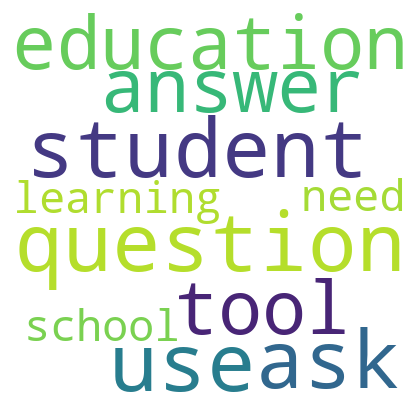

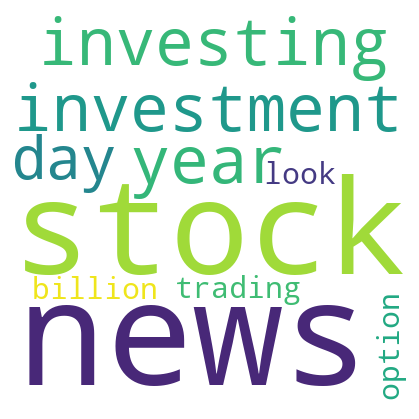

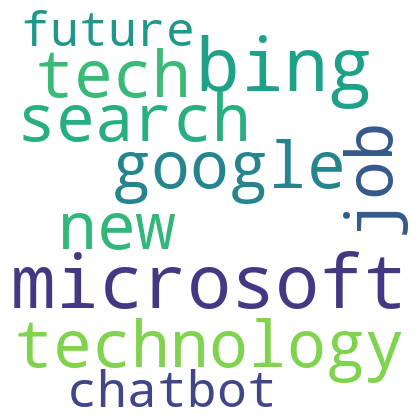

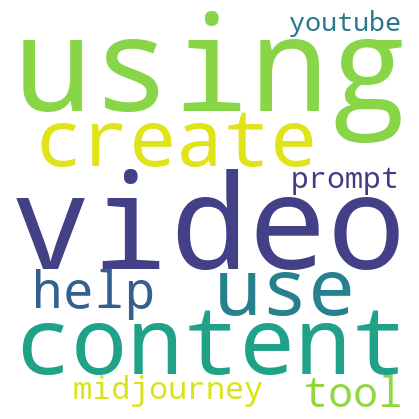

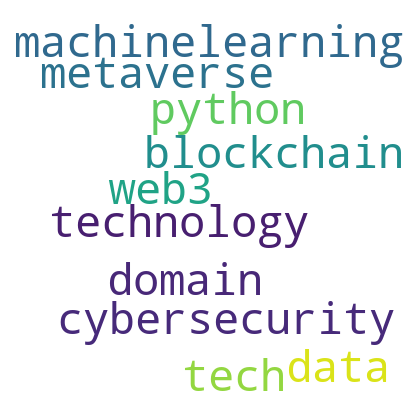

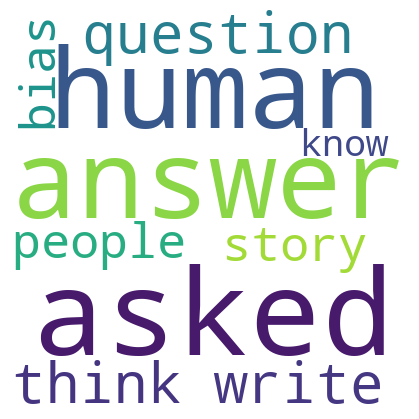

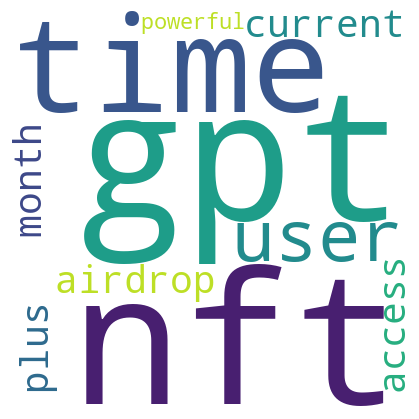

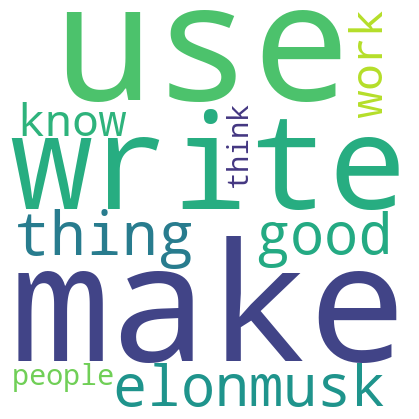

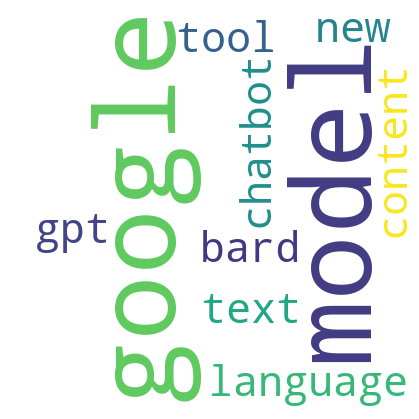

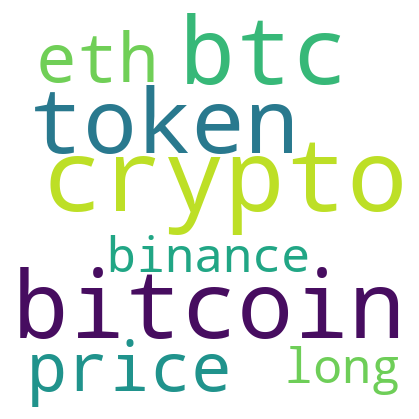

In [68]:
# Create the "Figures" directory if it doesn't exist
figures_dir = 'Figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    # Get top words for the topic
    top_words_indices = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_indices]  # Get actual words
    
    # Create word cloud object with smaller dimensions
    wordcloud = WordCloud(width = 400, height = 400,  # Adjust width and height
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(' '.join(top_words))
    
    # Plot word cloud
    plt.figure(figsize = (4, 4), facecolor = None)  # Adjust figure size
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    # Save the word cloud figure to the "Figures" directory
    fig_filename = os.path.join(figures_dir, f"topic_{topic_idx+1}_wordcloud.png")
    plt.savefig(fig_filename)  # Save word cloud as an image

    # Display word cloud
    plt.show() 

Topic modeling is not representative of engagement. Here, I have reordered each topic according to its engagement level based on likes and retweets. 

In [69]:
# Calculate average like count and average retweet count for each topic
topic_stats = pd.DataFrame(index=range(num_topics), columns=['Average Like Count', 'Average Retweet Count'])

for topic_idx, topic in enumerate(lda_model.components_):
    # Get indices of tweets belonging to the current topic
    topic_indices = lda_model.transform(bow_representation).argmax(axis=1) == topic_idx
    # Calculate average like count and average retweet count for tweets in this topic
    topic_like_count = data_subset.loc[topic_indices, 'like_count'].mean()
    topic_retweet_count = data_subset.loc[topic_indices, 'retweet_count'].mean()
    # Store the averages in the DataFrame
    topic_stats.loc[topic_idx] = [topic_like_count, topic_retweet_count]

# Sort topics based on average like count
sorted_topics_by_like = topic_stats.sort_values(by='Average Like Count', ascending=False)

# Sort topics based on average retweet count
sorted_topics_by_retweet = topic_stats.sort_values(by='Average Retweet Count', ascending=False)

# Display the sorted topics along with their associated average like count and average retweet count
print("\nTopics re-ranked by Average Like Count:")
for idx, row in sorted_topics_by_like.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")

print("\nTopics re-ranked by Average Retweet Count:")
for idx, row in sorted_topics_by_retweet.iterrows():
    print(f"Topic {idx + 1}: Avg Like Count={row['Average Like Count']}, Avg Retweet Count={row['Average Retweet Count']}")



Topics re-ranked by Average Like Count:
Topic 4: Avg Like Count=9.852708757637474, Avg Retweet Count=2.5037556008146638
Topic 10: Avg Like Count=9.028678304239401, Avg Retweet Count=3.0306178996952062
Topic 2: Avg Like Count=7.742755344418052, Avg Retweet Count=1.2204275534441804
Topic 6: Avg Like Count=7.153288679038103, Avg Retweet Count=1.2392821848185853
Topic 7: Avg Like Count=6.960136455977615, Avg Retweet Count=1.6060025298018321
Topic 8: Avg Like Count=6.937887862996519, Avg Retweet Count=0.7413237615412892
Topic 9: Avg Like Count=6.397723417249101, Avg Retweet Count=1.4040170998167876
Topic 1: Avg Like Count=6.390113640241614, Avg Retweet Count=1.0996655632529093
Topic 5: Avg Like Count=5.579929328621908, Avg Retweet Count=2.452756183745583
Topic 3: Avg Like Count=4.355355582736327, Avg Retweet Count=1.003442250567884

Topics re-ranked by Average Retweet Count:
Topic 10: Avg Like Count=9.028678304239401, Avg Retweet Count=3.0306178996952062
Topic 4: Avg Like Count=9.852708757

In [71]:
# Cosine similarity between topics
topic_similarity_matrix = cosine_similarity(lda_model.components_)

# Print similarity between topics
print("Similarity between topics:")
for i in range(num_topics):
    for j in range(i+1, num_topics):
        similarity = topic_similarity_matrix[i][j]
        print(f"Topic {i+1} vs Topic {j+1}: {similarity}")

# Create a topic feature matrix
topic_feature_matrix = lda_model.transform(bow_representation)

# Print the shape of the topic feature matrix
print("Shape of the topic feature matrix:", topic_feature_matrix.shape)

Similarity between topics:
Topic 1 vs Topic 2: 0.1286148689404724
Topic 1 vs Topic 3: 0.14569884041578124
Topic 1 vs Topic 4: 0.3562293887575372
Topic 1 vs Topic 5: 0.11421086005352526
Topic 1 vs Topic 6: 0.42137828172035335
Topic 1 vs Topic 7: 0.11213800671559314
Topic 1 vs Topic 8: 0.4335727863348614
Topic 1 vs Topic 9: 0.24464631270889883
Topic 1 vs Topic 10: 0.1121103888378738
Topic 2 vs Topic 3: 0.16021161649205448
Topic 2 vs Topic 4: 0.1623964484219865
Topic 2 vs Topic 5: 0.1377737519968723
Topic 2 vs Topic 6: 0.21941079845340453
Topic 2 vs Topic 7: 0.1324732011205711
Topic 2 vs Topic 8: 0.2123900358288931
Topic 2 vs Topic 9: 0.10787864470420368
Topic 2 vs Topic 10: 0.1878387163764522
Topic 3 vs Topic 4: 0.17070754705893046
Topic 3 vs Topic 5: 0.2641167245994041
Topic 3 vs Topic 6: 0.16260145308276877
Topic 3 vs Topic 7: 0.08895081146566731
Topic 3 vs Topic 8: 0.18000174160848853
Topic 3 vs Topic 9: 0.38005647260231884
Topic 3 vs Topic 10: 0.16487628953405206
Topic 4 vs Topic 5: 

This was my attempt at using Principal Component Analysis. It probably won't appear in the final draft, so if I find no use for it, I will delete it. 

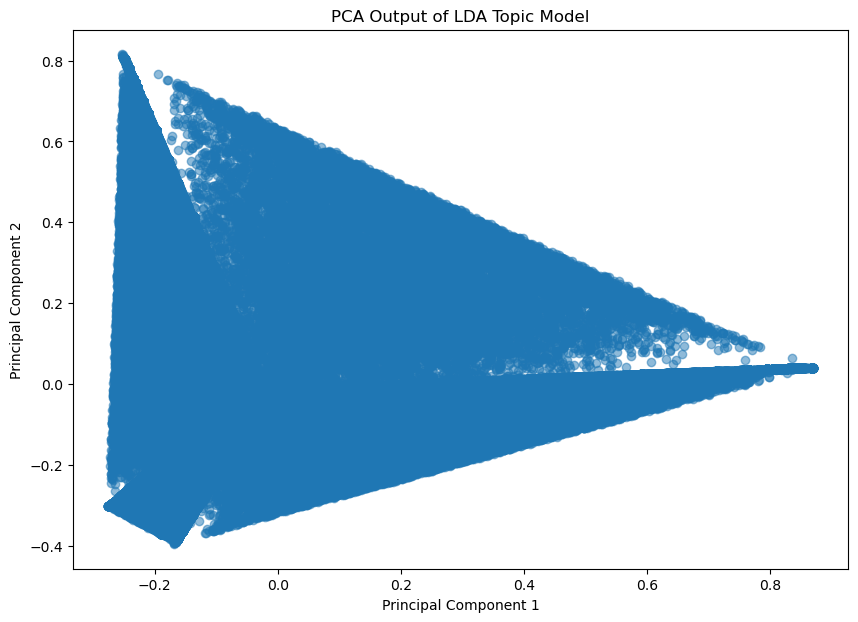

In [34]:
# Hyperparam for num_components for PCA model
num_components = 2  

# PCA model init
pca = PCA(n_components=num_components)

# Fit our PCA to the output of our LDA model
lda_output = lda_model.fit_transform(bow_representation)

pca_output = pca.fit_transform(lda_output)

# Create a figure to represent PCA
plt.figure(figsize=(10, 7))
plt.scatter(pca_output[:, 0], pca_output[:, 1], alpha=0.5)
plt.title('PCA Output of LDA Topic Model')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()